In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.model_selection import ParameterGrid

Models

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout)
        self.decoder = nn.Linear(in_features=hidden_size,
                                 out_features=output_size)
        
    def forward(self, x, hidden_state):
        embeddings = self.embedding(x)
        output, hidden_state = self.rnn(embeddings, hidden_state)
        output = self.decoder(output)
        return output, hidden_state

Training data

In [8]:
text = open("input.txt", 'r').read()
chars = sorted(list(set(text)))
data_size = len(text)
vocab_size = len(chars)
print("-------------------------------------------------------------------")
print("Preparing training data......")
print(f"Total number of characters in the text is: {data_size}")
print(f"Total number of unique characters is: {vocab_size}")
print(f"The unique characters are: {chars}")
print("-------------------------------------------------------------------")

chars_to_ids = {c:i for i, c in enumerate(chars)}
ids_to_chars = {i:c for i, c in enumerate(chars)}

encode = lambda s:[chars_to_ids[c] for c in s]
decode = lambda l:[ids_to_chars[i] for i in l]

data = torch.tensor(encode(text), dtype=torch.long)
split = int(0.9*len(data))
train_data = data[:split]
test_data = data[split:]
# train_data = torch.unsqueeze(data[:split], dim=1)
# test_data = torch.unsqueeze(data[split:], dim=1)

-------------------------------------------------------------------
Preparing training data......
Total number of characters in the text is: 1115394
Total number of unique characters is: 65
The unique characters are: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
-------------------------------------------------------------------


In [9]:
# Parameters
hidden_size = 256
seq_len = 128
num_layers = 3
dropout = 0
lr = 1e-4
epochs = 80
test_seq_len = 5000

# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Available device: {device}")

Available device: cuda


In [10]:
param_dict = {'hidden_size':[256],
              'dropout':[0],
              'lr':[1e-4],
              'epoch':[100],
              'num_layers':[1, 2, 3, 4, 5],
              'seq_len':[128]
              }
param_grid = ParameterGrid(param_dict)

In [11]:
def train(param_dict, device, train_data, vocab_size, experiment_name):
    
    model = RNN(input_size=vocab_size,
                hidden_size=param_dict['hidden_size'],
                output_size=vocab_size,
                num_layers=param_dict['num_layers'],
                dropout=param_dict['dropout']).to(device)
    
    # Record experiment
    log_dir = os.path.join('runs', experiment_name, 'num_layers', str(param_dict['num_layers']))
    writer = SummaryWriter(log_dir=log_dir)
    
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=param_dict['lr'])
    train_data = train_data.to(device)

    print("Training.....")
    for epoch in range(param_dict['epoch']):
        start_idx = torch.randint(0, 200, (1,))
        n = 0    
        total_loss = 0
        hidden_state = None
        seq_len = param_dict['seq_len']
        
        while True:
            input_seq = train_data[start_idx : start_idx+seq_len]
            target_seq = train_data[start_idx+1 : start_idx+seq_len+1]
            
            output_seq, hidden_state = model(input_seq, hidden_state)
            hidden_state = hidden_state.data
            
            loss = loss_fn(torch.squeeze(output_seq), torch.squeeze(target_seq))
            total_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            start_idx += seq_len
            n += 1
            
            if start_idx + seq_len + 1 > len(train_data) - 1:
                break
            
        if epoch % 10 == 0:    
            print(f"Epoch: {epoch}")
            print(f"Loss: {total_loss/n:.5f}") 
        
        writer.add_scalars(main_tag='Train Loss', tag_scalar_dict={'train_loss':total_loss/n}, global_step=epoch)
        
    writer.close()

In [15]:
for parameters in param_grid:
    train(param_dict=parameters, device=device, train_data=train_data, vocab_size=vocab_size, experiment_name='Model_layer_test')

Training.....
Epoch: 0
Loss: 2.19127
Epoch: 10
Loss: 1.48060
Epoch: 20
Loss: 1.39605
Epoch: 30
Loss: 1.35527
Epoch: 40
Loss: 1.33009
Epoch: 50
Loss: 1.31248
Epoch: 60
Loss: 1.29915
Epoch: 70
Loss: 1.28855
Epoch: 80
Loss: 1.27995
Epoch: 90
Loss: 1.27296
Training.....
Epoch: 0
Loss: 2.08041
Epoch: 10
Loss: 1.36790
Epoch: 20
Loss: 1.27747
Epoch: 30
Loss: 1.22736
Epoch: 40
Loss: 1.19161
Epoch: 50
Loss: 1.16344
Epoch: 60
Loss: 1.14068
Epoch: 70
Loss: 1.12135
Epoch: 80
Loss: 1.10521
Epoch: 90
Loss: 1.09241
Training.....
Epoch: 0
Loss: 2.05133
Epoch: 10
Loss: 1.31577
Epoch: 20
Loss: 1.21730
Epoch: 30
Loss: 1.15423
Epoch: 40
Loss: 1.10470
Epoch: 50
Loss: 1.06272
Epoch: 60
Loss: 1.02742
Epoch: 70
Loss: 0.99927
Epoch: 80
Loss: 0.98043
Epoch: 90
Loss: 0.96806
Training.....
Epoch: 0
Loss: 2.03250
Epoch: 10
Loss: 1.28886
Epoch: 20
Loss: 1.18252
Epoch: 30
Loss: 1.10670
Epoch: 40
Loss: 1.04269
Epoch: 50
Loss: 0.98930
Epoch: 60
Loss: 0.94776
Epoch: 70
Loss: 0.91954
Epoch: 80
Loss: 0.90249
Epoch: 90
Lo

In [16]:
def train_tuning(param_dict, device, train_data, vocab_size, experiment_name):
    
    model = RNN(input_size=vocab_size,
                hidden_size=param_dict['hidden_size'],
                output_size=vocab_size,
                num_layers=param_dict['num_layers'],
                dropout=param_dict['dropout']).to(device)
    
    # Record experiment
    log_dir = os.path.join('runs', experiment_name,'hidden_size', str(param_dict['hidden_size']), 'seq_len', str(param_dict['seq_len']))
    writer = SummaryWriter(log_dir=log_dir)
    
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=param_dict['lr'])
    train_data = train_data.to(device)

    print("Training.....")
    for epoch in range(param_dict['epoch']):
        start_idx = torch.randint(0, 200, (1,))
        n = 0    
        total_loss = 0
        hidden_state = None
        seq_len = param_dict['seq_len']
        
        while True:
            input_seq = train_data[start_idx : start_idx+seq_len]
            target_seq = train_data[start_idx+1 : start_idx+seq_len+1]
            
            output_seq, hidden_state = model(input_seq, hidden_state)
            hidden_state = hidden_state.data
            
            loss = loss_fn(torch.squeeze(output_seq), torch.squeeze(target_seq))
            total_loss += loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            start_idx += seq_len
            n += 1
            
            if start_idx + seq_len + 1 > len(train_data) - 1:
                break
            
        if epoch % 10 == 0:    
            print(f"Epoch: {epoch}")
            print(f"Loss: {total_loss/n:.5f}") 
        
        writer.add_scalars(main_tag='Train Loss', tag_scalar_dict={'train_loss':total_loss/n}, global_step=epoch)
        
    writer.close()

In [17]:
param_dict = {'hidden_size':[128, 256, 512],
              'dropout':[0],
              'lr':[1e-4],
              'epoch':[100],
              'num_layers':[3],
              'seq_len':[64, 128, 256]
              }
param_grid = ParameterGrid(param_dict)

In [18]:
for parameters in param_grid:
    train_tuning(param_dict=parameters, device=device, train_data=train_data, vocab_size=vocab_size, experiment_name='Model_parameter_test')

Training.....
Epoch: 0
Loss: 2.10892
Epoch: 10
Loss: 1.42079
Epoch: 20
Loss: 1.34577
Epoch: 30
Loss: 1.30976
Epoch: 40
Loss: 1.28755
Epoch: 50
Loss: 1.27204
Epoch: 60
Loss: 1.26041
Epoch: 70
Loss: 1.25174
Epoch: 80
Loss: 1.24488
Epoch: 90
Loss: 1.23932
Training.....
Epoch: 0
Loss: 2.20595
Epoch: 10
Loss: 1.47235
Epoch: 20
Loss: 1.38336
Epoch: 30
Loss: 1.34059
Epoch: 40
Loss: 1.31394
Epoch: 50
Loss: 1.29501
Epoch: 60
Loss: 1.28055
Epoch: 70
Loss: 1.26901
Epoch: 80
Loss: 1.25971
Epoch: 90
Loss: 1.25200
Training.....
Epoch: 0
Loss: 2.34609
Epoch: 10
Loss: 1.53484
Epoch: 20
Loss: 1.42889
Epoch: 30
Loss: 1.37848
Epoch: 40
Loss: 1.34725
Epoch: 50
Loss: 1.32513
Epoch: 60
Loss: 1.30817
Epoch: 70
Loss: 1.29465
Epoch: 80
Loss: 1.28355
Epoch: 90
Loss: 1.27429
Training.....
Epoch: 0
Loss: 1.93336
Epoch: 10
Loss: 1.27232
Epoch: 20
Loss: 1.17568
Epoch: 30
Loss: 1.11317
Epoch: 40
Loss: 1.06824
Epoch: 50
Loss: 1.03899
Epoch: 60
Loss: 1.02295
Epoch: 70
Loss: 1.01384
Epoch: 80
Loss: 1.01039
Epoch: 90
Lo

In [24]:

# %load_ext tensorboard
%tensorboard --logdir runs --host localhost

Reusing TensorBoard on port 6006 (pid 17664), started 0:00:10 ago. (Use '!kill 17664' to kill it.)

In [27]:
param_dict_best = {'hidden_size':256,
                   'dropout':0,
                   'lr':1e-4,
                   'epoch':100,
                   'num_layers':3,
                   'seq_len':256
                }

In [28]:
bestmodel = RNN(input_size=vocab_size,
                hidden_size=param_dict_best['hidden_size'],
                output_size=vocab_size,
                num_layers=param_dict_best['num_layers'],
                dropout=param_dict_best['dropout']).to(device)

bestmodel.train()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=bestmodel.parameters(), lr=param_dict_best['lr'])
train_data = train_data.to(device)

print("Training.....")
for epoch in range(param_dict_best['epoch']):
    start_idx = torch.randint(0, 200, (1,))
    n = 0    
    total_loss = 0
    hidden_state = None
    seq_len = param_dict_best['seq_len']
    
    while True:
        input_seq = train_data[start_idx : start_idx+seq_len]
        target_seq = train_data[start_idx+1 : start_idx+seq_len+1]
        
        output_seq, hidden_state = bestmodel(input_seq, hidden_state)
        hidden_state = hidden_state.data
        
        loss = loss_fn(torch.squeeze(output_seq), torch.squeeze(target_seq))
        total_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        start_idx += seq_len
        n += 1
        
        if start_idx + seq_len + 1 > len(train_data) - 1:
            break
        
    if epoch % 10 == 0:    
        print(f"Epoch: {epoch}")
        print(f"Loss: {total_loss/n:.5f}") 

Training.....
Epoch: 0
Loss: 2.16721
Epoch: 10
Loss: 1.36607
Epoch: 20
Loss: 1.26163
Epoch: 30
Loss: 1.20100
Epoch: 40
Loss: 1.15436
Epoch: 50
Loss: 1.11471
Epoch: 60
Loss: 1.07953
Epoch: 70
Loss: 1.04722
Epoch: 80
Loss: 1.01798
Epoch: 90
Loss: 0.99454


In [29]:
def generate(model, test_seq_len, test_data):
    
    test_data = test_data.to(device)
    print("Generating Texts.....")

    char_num = 0
    hidden_state_gen = None
    start_idx_gen = torch.randint(0, 200, (1,))
    input_seq_gen = test_data[start_idx_gen : start_idx_gen+seq_len]
    while True:
        
        input = input_seq_gen[-seq_len:]
        output, hidden_state_gen = model(input, hidden_state_gen)
        output = F.softmax(torch.squeeze(output[-1]), dim=0)
        dist = Categorical(output)
        index = dist.sample()
        print(ids_to_chars[index.item()], end='')
        
        input_seq_gen = torch.cat((input_seq_gen, index.unsqueeze(dim=0)), dim=0)
        char_num += 1
        
        if char_num > test_seq_len:
            break
    print('\n')

In [30]:
generate(bestmodel, test_seq_len, test_data)

Generating Texts.....
troupest heart,
To use you have hearing of commisside,
To-day, look up with self indeed in me?

PETRUCHIO:
Play you this.
Good Besore these man Isabel,
Bear's that? whence, ho can we are,
And fellow captage being.

DUKE VINCENTIO:
Ver your housefoak'd him, they will fear her clock;
And he would have of God of all?

SICINIUS:
Why, you my pating; now, ho, nothing stood his face.

TRANIO:
Master, to fear fear'd us account:
If wear thee collece those words, possess some nor men
To see her carriage of Tenderness she
pleasure of your censio?

PETRUCHIO:
But seek to come not, for the
shores of a maid of son and the cherish?
Than pincen, sir, thou art too at
Beneath to look and many hour and bebulders
head in himself, if you kner the middle me!
For I here he executed
into an hummer leave his countrymen are
As she will have me a best of all,
Look to-night, afisess from his name?
Go, boint by any 'twere were
there I say about him, nor heaven,
Immediather forth. God you make

Image Generation

Dataset

In [31]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10
import matplotlib.pyplot as plt

In [32]:
path = '..\Data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255).type(torch.long))
])
train_data = FashionMNIST(root=path, train=True, download=True, transform=transform)
test_data = FashionMNIST(root=path, train=False, download=True, transform=transform)
# train_data = MNIST(root=path, train=True, download=True, transform=ToTensor())
# test_data = MNIST(root=path, train=False, download=True, transform=ToTensor()) 

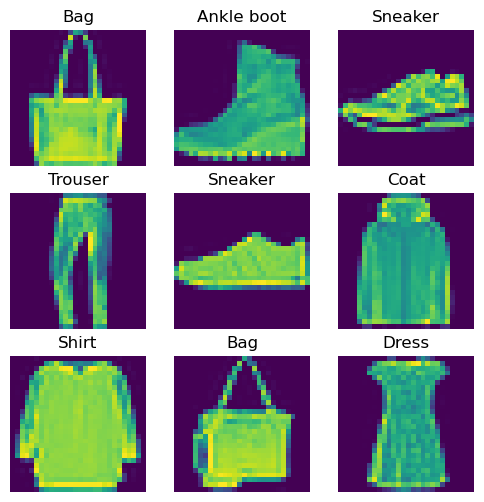

In [33]:
fig = plt.figure(figsize=(6, 6))
for i in range(1, 10):
    idx = torch.randint(0, len(train_data), (1,)).item()
    img, label = train_data[idx]
    fig.add_subplot(3, 3, i)
    plt.imshow(img.squeeze())
    plt.title(train_data.classes[label])
    plt.axis(False)

In [ ]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [ ]:
train_data_flatten = torch.empty((1), dtype=torch.long)
i = 1
for x, _ in train_data_loader:
    flattened = x.flatten()
    train_data_flatten = torch.cat((train_data_flatten, flattened))

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super(ImageRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout)
        self.decoder = nn.Linear(in_features=hidden_size,
                                 out_features=output_size)
        
    def forward(self, x, hidden_state):
        embeddings = self.embedding(x)
        output, hidden_state = self.rnn(embeddings, hidden_state)
        output = self.decoder(output)
        return output, hidden_state

In [ ]:
ImgRNN = ImageRNN(input_size=256, 
                  hidden_size=512,
                  output_size=256,
                  num_layers=1,
                  dropout=0).to(device)

In [ ]:
train(ImgRNN, epochs=40, lr=0.0003, device=device, train_data=train_data_flatten, seq_len=128)